Loaded 300 images.
Total Data: 300
Train: (240, 64, 64, 3), Test: (60, 64, 64, 3)
Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  6291968   
                                                                 
 batch_normalization (BatchN  multiple                 2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 dense_1 (Dense)             multiple                  131328    
                                                                 
 batch_normalization_1 (Batc  multiple                 1024      
 hNormalization)                                                 
                                               

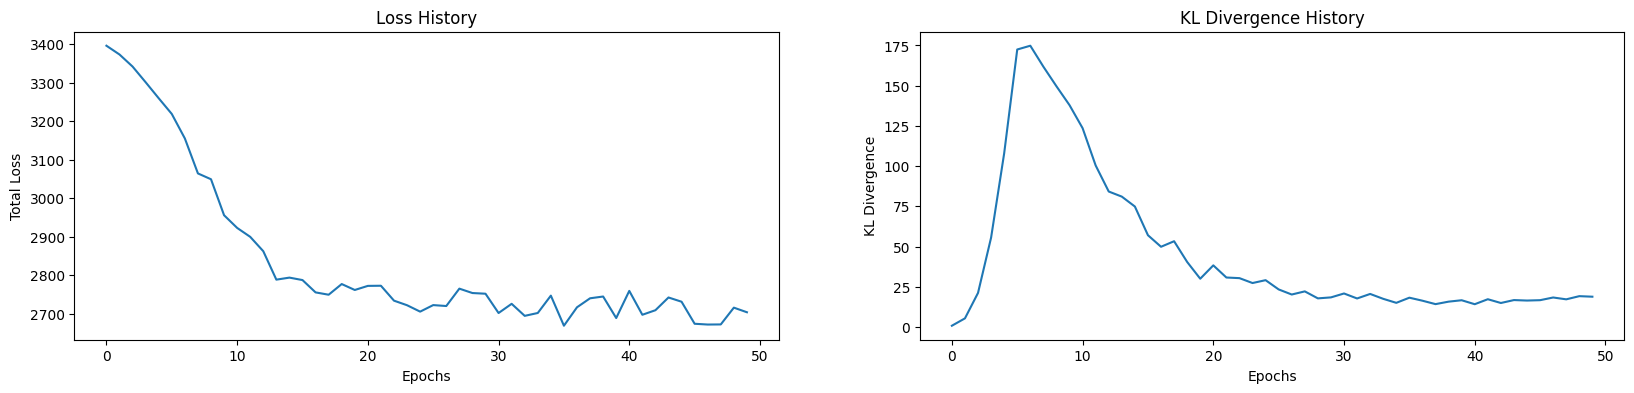

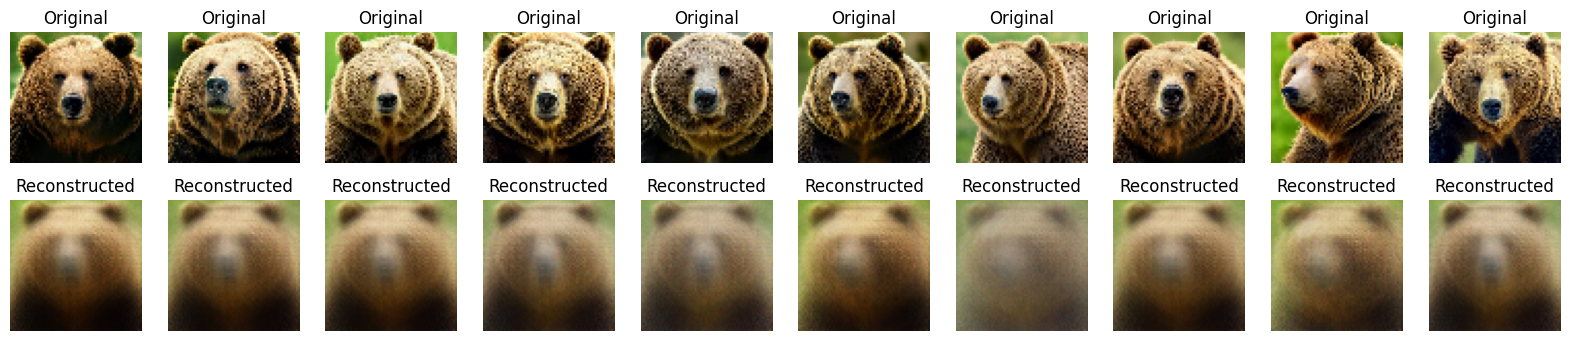

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

# --- 1. Load Dataset ---
# Adjust this path to where your Bear dataset is actually located
image_path = "./Dataset/" 

images = []

# Ensure directory exists before loading
if os.path.exists(image_path):
    for filename in os.listdir(image_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            # Load image, target size 64x64 as per implied input dimension (12288 / 3 = 4096 -> 64x64)
            img = tf.keras.preprocessing.image.load_img(os.path.join(image_path, filename), target_size=(64, 64))
            img = tf.keras.preprocessing.image.img_to_array(img)
            images.append(img)
    print(f"Loaded {len(images)} images.")
else:
    print(f"Error: Path {image_path} not found.")

# --- 2. Data Preprocessing ---
images = np.asarray(images)

# Shuffle
indices = np.arange(images.shape[0])
np.random.shuffle(indices)
images = images[indices]

# Normalize (Convert to float32 and divide by 255)
images = images.astype(np.float32) / 255.0

# Split Dataset (80% Train, 20% Test)
total_data = len(images)
train_count = int(0.8 * total_data)

x_train = images[:train_count]
x_test = images[train_count:]

print(f"Total Data: {total_data}")
print(f"Train: {x_train.shape}, Test: {x_test.shape}")

# --- 3. Configuration & Constants ---
BATCH_SIZE = 100 # Flexible, but 100 is standard
IMAGE_ORIGINAL_SHAPE = (64, 64, 3)
IMAGE_SIZE = 64 * 64 * 3  # 12288
HIDDEN_DIM = 512
LATENT_DIM = 32
MAX_EPOCHS = 50 # Minimum 50 epochs as per Bear PDF
LEARNING_RATE = 0.0001

# --- 4. Define VAE Model (Fully Connected / Dense) ---
class VAE(tf.keras.Model):
    def __init__(self, dim, **kwargs):
        super(VAE, self).__init__(**kwargs)
        h_dim = dim[0] # 512
        z_dim = dim[1] # 32

        # -- Encoder --
        # Layer 1
        self.fc1 = tf.keras.layers.Dense(h_dim, activation=tf.nn.relu) 
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.do1 = tf.keras.layers.Dropout(0.3) # Assuming default dropout, adjust if specific rate needed
        
        # Layer 2
        self.fc2_intermediate = tf.keras.layers.Dense(256, activation=tf.nn.relu) # Based on PDF graph
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.do2 = tf.keras.layers.Dropout(0.3)
        
        # Layer 3 (connecting to latent)
        self.fc3_intermediate = tf.keras.layers.Dense(256, activation=tf.nn.relu)
        self.do3 = tf.keras.layers.Dropout(0.3)

        # Latent Space (Mean & Log Variance)
        self.fc_mean = tf.keras.layers.Dense(z_dim)
        self.fc_log_var = tf.keras.layers.Dense(z_dim)

        # -- Decoder --
        # Layer 1
        self.fc4 = tf.keras.layers.Dense(256, activation=tf.nn.relu)
        self.bn4 = tf.keras.layers.BatchNormalization()
        self.do4 = tf.keras.layers.Dropout(0.3)

        # Layer 2
        self.fc5 = tf.keras.layers.Dense(512, activation=tf.nn.relu)
        self.bn5 = tf.keras.layers.BatchNormalization()
        
        # Output Layer
        self.fc_out = tf.keras.layers.Dense(IMAGE_SIZE) # 12288
        self.bn_out = tf.keras.layers.BatchNormalization()
        
    def encode(self, x):
        # Matches "Figure 1. Model Visualization" flow
        h = self.fc1(x)
        h = self.bn1(h)
        h = self.do1(h)
        
        h = self.fc2_intermediate(h)
        h = self.bn2(h)
        h = self.do2(h)
        
        h = self.fc3_intermediate(h)
        h = self.do3(h)
        
        return self.fc_mean(h), self.fc_log_var(h)

    def reparameterize(self, mu, log_var):
        std = tf.exp(log_var * 0.5)
        eps = tf.random.normal(tf.shape(std))
        return mu + eps * std
    
    def decode_logits(self, z):
        # Matches Decoder architecture in PDF
        h = self.fc4(z)
        h = self.bn4(h)
        h = self.do4(h)
        
        h = self.fc5(h)
        h = self.bn5(h)
        
        h = self.fc_out(h)
        h = self.bn_out(h)
        return h
    
    def decode(self, z):
        return tf.nn.sigmoid(self.decode_logits(z))

    def call(self, inputs, training=None, mask=None):
        mu, log_var = self.encode(inputs)
        z = self.reparameterize(mu, log_var)
        x_recon_logits = self.decode_logits(z)
        return x_recon_logits, mu, log_var

# --- 5. Initialize & Compile Model ---
model = VAE([HIDDEN_DIM, LATENT_DIM])

# Test with dummy data to build the model (optional but good for summary)
dummy_input = tf.zeros((BATCH_SIZE, IMAGE_SIZE))
model(dummy_input)
model.summary()

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

# Prepare Dataset for Training
# Flatten the images for Dense layers: (Batch, 64, 64, 3) -> (Batch, 12288)
# We handle reshaping inside the training loop or via map
dataset = tf.data.Dataset.from_tensor_slices(x_train)
dataset = dataset.shuffle(BATCH_SIZE * 5).batch(BATCH_SIZE)

# --- 6. Training Loop ---
loss_history = []
kl_div_history = []

print(f"Starting training for {MAX_EPOCHS} epochs...")

for epoch in range(MAX_EPOCHS):
    for x in dataset:
        # Reshape batch to (Batch_Size, 12288)
        x = tf.reshape(x, [-1, IMAGE_SIZE])
        
        with tf.GradientTape() as tape:
            x_reconstruction_logits, mu, log_var = model(x)

            # Reconstruction Loss (Binary Crossentropy / Sigmoid Crossentropy)
            reconstruction_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=x, logits=x_reconstruction_logits)
            reconstruction_loss = tf.reduce_sum(reconstruction_loss) / BATCH_SIZE

            # KL Divergence Loss
            kl_div = -0.5 * tf.reduce_sum(1. + log_var - tf.square(mu) - tf.exp(log_var), axis=-1)
            kl_div = tf.reduce_mean(kl_div)

            # Total Loss
            loss = reconstruction_loss + kl_div

        gradients = tape.gradient(loss, model.trainable_variables)
        # Gradient Clipping to prevent explosion
        gradients = [tf.clip_by_norm(g, 15) for g in gradients]
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Log progress
    print(f"Epoch[{epoch+1}/{MAX_EPOCHS}], Recon Loss: {float(reconstruction_loss):.2f}, KL Div: {float(kl_div):.2f}, Total Loss: {float(loss):.2f}")
    kl_div_history.append(float(kl_div))
    loss_history.append(float(loss))

# --- 7. Plotting Training History ---
plt.figure(figsize=(20, 4))

plt.subplot(1, 2, 1)
plt.plot(loss_history)
plt.xlabel("Epochs")
plt.ylabel("Total Loss")
plt.title("Loss History")

plt.subplot(1, 2, 2)
plt.plot(kl_div_history)
plt.xlabel("Epochs")
plt.ylabel("KL Divergence")
plt.title("KL Divergence History")

plt.show()

# --- 8. Visualization (Reconstruction) ---
# Take a batch from test set
test_batch = x_test[:10] 
# Reshape for model
test_batch_flat = tf.reshape(test_batch, [-1, IMAGE_SIZE])

# Predict
mu, log_var = model.encode(test_batch_flat)
z = model.reparameterize(mu, log_var)
recon_images_logits = model.decode(z)

# Reshape back to image dimensions
recon_images = tf.reshape(recon_images_logits, [-1, 64, 64, 3]).numpy()

# Plot Original vs Reconstructed
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_batch[i])
    plt.title("Original")
    plt.axis("off")

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon_images[i])
    plt.title("Reconstructed")
    plt.axis("off")
plt.show()